# Imports and base model

In [1]:
%reset
import tensorflow as tf
import keras
import sklearn
from keras import models
from keras import layers
from keras import optimizers
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

keras.__version__

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


'2.4.3'

In [2]:
import os, shutil, glob
from IPython.display import Image, display

In [3]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [4]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# Database directory structure and setup

In [5]:
# The directory where the datasets are stored
base = 'datasets'

# Directory with good basement pictures
good_basement_dir = os.path.join(base, 'good basement streetviews')

# Directory with good non basement pictures
good_non_basement_dir = os.path.join(base, 'good non basement streetviews')

# Directories for our training, validation
# and test splits. 
train_dir = os.path.join(base, 'train')
test_dir = os.path.join(base, 'test')
validation_dir = os.path.join(base, 'validation')

# Directory with our training basement pictures
train_basement_dir = os.path.join(train_dir, 'basement')

# Directory with our training non basement pictures
train_non_basement_dir = os.path.join(train_dir, 'non_basement')

# Directory with our validation basement pictures
validation_basement_dir = os.path.join(validation_dir, 'basement')

# Directory with our validation non basement pictures
validation_non_basement_dir = os.path.join(validation_dir, 'non_basement')

# Directory with our test basement pictures
test_basement_dir = os.path.join(test_dir, 'basement')

# Directory with our test non basement pictures
test_non_basement_dir = os.path.join(test_dir, 'non_basement')


In [6]:
#Removes all files from the training, validation and test folders
for file in os.listdir(train_basement_dir):
    os.remove(os.path.join(train_basement_dir, file))
for file in os.listdir(train_non_basement_dir):
    os.remove(os.path.join(train_non_basement_dir, file))

for file in os.listdir(validation_basement_dir):
    os.remove(os.path.join(validation_basement_dir, file))
for file in os.listdir(validation_non_basement_dir):
    os.remove(os.path.join(validation_non_basement_dir, file))

for file in os.listdir(test_basement_dir):
    os.remove(os.path.join(test_basement_dir, file))
for file in os.listdir(test_non_basement_dir):
    os.remove(os.path.join(test_non_basement_dir, file))

In [7]:
import random
random.seed(340)
good_basement_files = os.listdir(good_basement_dir)
good_non_basement_files = os.listdir(good_non_basement_dir)

n_test = 40

basement_test_sample = random.sample(good_basement_files, n_test)
basement_train_sample = [file for file in good_basement_files if file not in basement_test_sample]

non_basement_test_sample = random.sample(good_non_basement_files, n_test)
non_basement_train_sample = [file for file in good_non_basement_files if file not in non_basement_test_sample]

for file in basement_test_sample:
    shutil.copy(os.path.join(good_basement_dir, file), test_basement_dir)
for file in basement_train_sample:
    shutil.copy(os.path.join(good_basement_dir, file), train_basement_dir)

for file in non_basement_test_sample:
    shutil.copy(os.path.join(good_non_basement_dir, file), test_non_basement_dir)
for file in non_basement_train_sample:
    shutil.copy(os.path.join(good_non_basement_dir, file), train_non_basement_dir)

In [8]:
print('total training + validation images:', len(os.listdir(train_basement_dir) + os.listdir(train_non_basement_dir)))

total training + validation images: 600


In [9]:
print('total test images:', len(os.listdir(test_basement_dir) + os.listdir(test_non_basement_dir)))

total test images: 80


# Model training

In [13]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255, #normalize data
    #rotation_range=40,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #brightness_range=[0.3,0.9],
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
    #fill_mode='nearest'
    )

test_datagen = ImageDataGenerator(rescale=1./255) #used for validation

test_datagen2 = ImageDataGenerator(rescale=1./255)

test_generator2 = test_datagen2.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=8,
        class_mode='binary',
        shuffle=False)

Found 80 images belonging to 2 classes.


In [62]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Found 1905 images belonging to 2 classes.
Found 478 images belonging to 2 classes.
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/14
120/120 - 345s - loss: 0.1192 - acc: 0.9506 - val_loss: 0.1432 - val_acc: 0.9511
Epoch 2/14
120/120 - 339s - loss: 0.0429 - acc: 0.9811 - val_loss: 0.1409 - val_acc: 0.9622
Epoch 3/14
120/120 - 339s - loss: 0.0308 - acc: 0.9889 - val_loss: 0.1386 - val_acc: 0.9444
Epoch 4/14
120/120 - 342s - loss: 0.0272 - acc: 0.9906 - val_loss: 0.1515 - val_acc: 0.9622
Epoch 5/14
120/120 - 339s - loss: 0.0241 - acc: 0.9911 - val_loss: 0.1465 - val_acc: 0.9600
Epoch 6/14
120/120 - 339s - loss: 0.0230 - acc: 0.9894 - val_loss: 0.1854 - val_acc: 0.9533
Epoch 7/14
120/120 - 339s - loss: 0.0247 - acc: 0.9883 - val_loss: 0.1492 - val_acc: 0.9644
Epoch 8/14
120/120 - 348s - loss: 0.0226 - acc: 0.9906 - val_loss: 0.2330 - val_acc: 0.9444
Epoch 9/14
120/120 - 339s - loss: 0.0168 - acc: 0.9922 - val_loss: 0.2482 - val_acc:

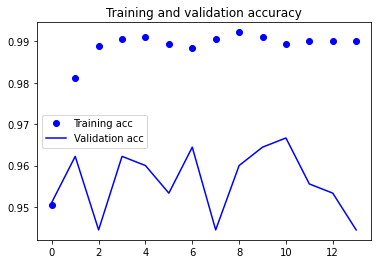

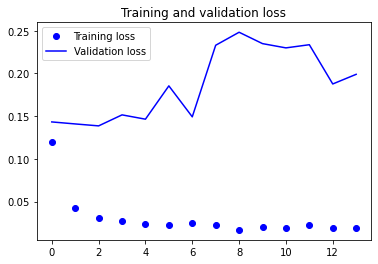

10/10 [==============================] - 79s 8s/step - loss: 0.2527 - acc: 0.9300
Score for fold 1: loss of 0.2527303695678711; acc of 93.00000071525574%
[[290  10]
 [ 32 268]]
Found 1906 images belonging to 2 classes.
Found 477 images belonging to 2 classes.
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/14
120/120 - 341s - loss: 0.1373 - acc: 0.9440 - val_loss: 0.0273 - val_acc: 0.9867
Epoch 2/14
120/120 - 337s - loss: 0.0566 - acc: 0.9776 - val_loss: 0.0161 - val_acc: 0.9956
Epoch 3/14
120/120 - 338s - loss: 0.0340 - acc: 0.9826 - val_loss: 0.0105 - val_acc: 0.9978
Epoch 4/14
120/120 - 346s - loss: 0.0256 - acc: 0.9877 - val_loss: 0.0107 - val_acc: 0.9956
Epoch 5/14
120/120 - 336s - loss: 0.0253 - acc: 0.9882 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 6/14
120/120 - 337s - loss: 0.0232 - acc: 0.9910 - val_loss: 0.0088 - val_acc: 0.9978
Epoch 7/14
120/120 - 338s - loss: 0.0222 - acc: 0.9882 - val_loss: 0.0072 - val_acc: 0.9978

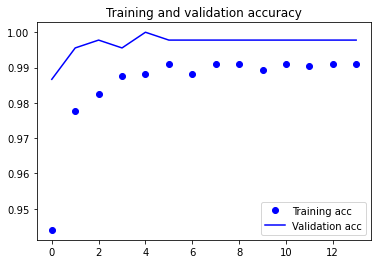

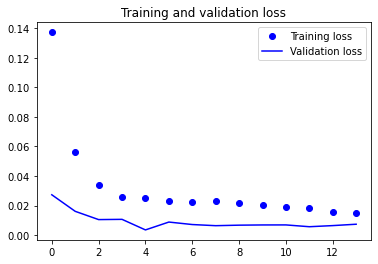

10/10 [==============================] - 81s 8s/step - loss: 0.8609 - acc: 0.8650
Score for fold 2: loss of 0.8609285354614258; acc of 86.50000095367432%
[[295   5]
 [ 76 224]]
Found 1907 images belonging to 2 classes.
Found 476 images belonging to 2 classes.
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/14
120/120 - 342s - loss: 0.0957 - acc: 0.9631 - val_loss: 0.0345 - val_acc: 0.9867
Epoch 2/14
120/120 - 338s - loss: 0.0249 - acc: 0.9888 - val_loss: 0.0281 - val_acc: 0.9911
Epoch 3/14
120/120 - 337s - loss: 0.0193 - acc: 0.9922 - val_loss: 0.0329 - val_acc: 0.9911
Epoch 4/14
120/120 - 337s - loss: 0.0151 - acc: 0.9938 - val_loss: 0.0367 - val_acc: 0.9911
Epoch 5/14
120/120 - 337s - loss: 0.0172 - acc: 0.9916 - val_loss: 0.0360 - val_acc: 0.9911
Epoch 6/14
120/120 - 337s - loss: 0.0154 - acc: 0.9927 - val_loss: 0.0448 - val_acc: 0.9911
Epoch 7/14
120/120 - 339s - loss: 0.0168 - acc: 0.9927 - val_loss: 0.0208 - val_acc: 0.9933

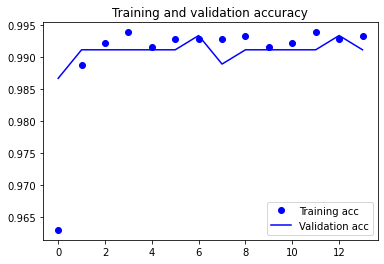

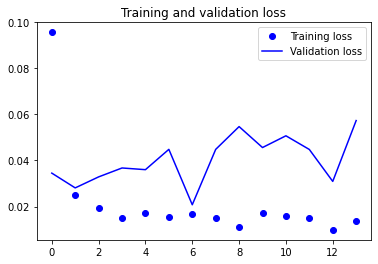

10/10 [==============================] - 76s 8s/step - loss: 1.3733 - acc: 0.8333
Score for fold 3: loss of 1.3733115196228027; acc of 83.33333134651184%
[[297   3]
 [ 97 203]]
Found 1907 images belonging to 2 classes.
Found 476 images belonging to 2 classes.
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/14
120/120 - 342s - loss: 0.0799 - acc: 0.9687 - val_loss: 0.0277 - val_acc: 0.9867
Epoch 2/14
120/120 - 343s - loss: 0.0218 - acc: 0.9938 - val_loss: 0.0279 - val_acc: 0.9889
Epoch 3/14
120/120 - 345s - loss: 0.0172 - acc: 0.9933 - val_loss: 0.0322 - val_acc: 0.9867
Epoch 4/14
120/120 - 347s - loss: 0.0163 - acc: 0.9933 - val_loss: 0.0363 - val_acc: 0.9867
Epoch 5/14
120/120 - 345s - loss: 0.0143 - acc: 0.9944 - val_loss: 0.0354 - val_acc: 0.9867
Epoch 6/14
120/120 - 351s - loss: 0.0153 - acc: 0.9933 - val_loss: 0.0427 - val_acc: 0.9867
Epoch 7/14
120/120 - 345s - loss: 0.0141 - acc: 0.9944 - val_loss: 0.0548 - val_acc: 0.9867

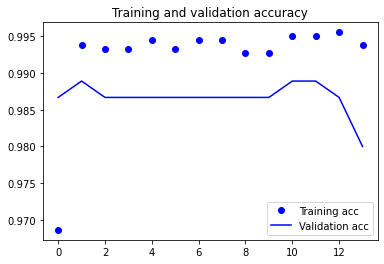

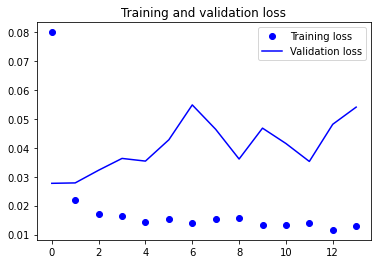

10/10 [==============================] - 77s 8s/step - loss: 2.2816 - acc: 0.7933
Score for fold 4: loss of 2.2816195487976074; acc of 79.3333351612091%
[[298   2]
 [122 178]]
Found 1907 images belonging to 2 classes.
Found 476 images belonging to 2 classes.
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/14
120/120 - 340s - loss: 0.1212 - acc: 0.9597 - val_loss: 0.0208 - val_acc: 0.9889
Epoch 2/14
120/120 - 347s - loss: 0.0190 - acc: 0.9927 - val_loss: 0.0202 - val_acc: 0.9889
Epoch 3/14
120/120 - 346s - loss: 0.0179 - acc: 0.9933 - val_loss: 0.0215 - val_acc: 0.9844
Epoch 4/14
120/120 - 336s - loss: 0.0171 - acc: 0.9916 - val_loss: 0.0196 - val_acc: 0.9911
Epoch 5/14
120/120 - 338s - loss: 0.0116 - acc: 0.9950 - val_loss: 0.0225 - val_acc: 0.9889
Epoch 6/14
120/120 - 336s - loss: 0.0161 - acc: 0.9933 - val_loss: 0.0238 - val_acc: 0.9844
Epoch 7/14
120/120 - 336s - loss: 0.0139 - acc: 0.9944 - val_loss: 0.0237 - val_acc: 0.9844


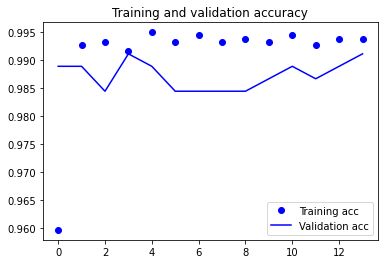

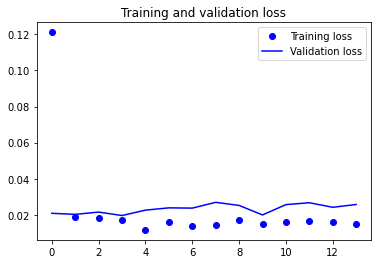

10/10 [==============================] - 76s 8s/step - loss: 1.5603 - acc: 0.8450
Score for fold 5: loss of 1.5602786540985107; acc of 84.50000286102295%
[[290  10]
 [ 83 217]]
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.2527303695678711 - Accuracy: 93.00000071525574%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.8609285354614258 - Accuracy: 86.50000095367432%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.3733115196228027 - Accuracy: 83.33333134651184%
------------------------------------------------------------------------
> Fold 4 - Loss: 2.2816195487976074 - Accuracy: 79.3333351612091%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.5602786540985107 - Accuracy: 84.50000286102295%
------------------------------------

In [63]:
k = 5

random.shuffle(basement_train_sample)
basement_splits = np.array_split(basement_train_sample, k)

random.shuffle(non_basement_train_sample)
non_basement_splits = np.array_split(non_basement_train_sample, k)

acc_per_fold = []
loss_per_fold = []

for i in range(1, k+1):
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])
    
    basement_validation_sample = list(basement_splits[i-1])
    non_basement_validation_sample = list(non_basement_splits[i-1])
    
    for file in basement_validation_sample:
        shutil.copy(os.path.join(good_basement_dir, file), validation_basement_dir)
        os.remove(os.path.join(train_basement_dir, file))
    
    for file in non_basement_validation_sample:
        shutil.copy(os.path.join(good_non_basement_dir, file), validation_non_basement_dir)
        os.remove(os.path.join(train_non_basement_dir, file))
        
    train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        target_size=(150, 150),
        batch_size=4,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')    
        
    validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='binary')
    
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {i} ...')
    
    history = model.fit(
        train_generator,
        steps_per_epoch=120, #training size/training batch size
        epochs=14,
        validation_data=validation_generator,
        validation_steps=30, #validation size/validation batch size
        verbose=2)
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

    scores = model.evaluate(test_generator2)
    print(f'Score for fold {i}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    probabilities = model.predict(test_generator2)
    y_true = np.array([0] * n_test + [1] * n_test)
    y_pred = probabilities > 0.5

    print(confusion_matrix(y_true, y_pred))
    
    model.save(f'vgg16_5fold_no_augmentation_14epochs_fold{i}.h5')
    #model.save(f'vgg16_5fold_augmentation_no_brightness_14epochs_fold{i}.h5')
    #model.save(f'vgg16_5fold_augmentation_brightness_14epochs_fold{i}.h5')
    #model.save(f'vgg16_5fold_no_augmentation_14epochs_all_data_fold{i}.h5')

    for file in os.listdir(validation_basement_dir):
        shutil.copy(os.path.join(validation_basement_dir, file), train_basement_dir)
        os.remove(os.path.join(validation_basement_dir, file))
    for file in os.listdir(validation_non_basement_dir):
        shutil.copy(os.path.join(validation_non_basement_dir, file), train_non_basement_dir)
        os.remove(os.path.join(validation_non_basement_dir, file))
    
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

# Grad-CAM

In [96]:
#model = models.load_model('vgg16_5fold_no_augmentation_14epochs_fold5.h5')
#gradcam_save = 'gradcam_no_augmentation_fold5'

#model = models.load_model('vgg16_5fold_augmentation_no_brightness_14epochs_fold5.h5')
#gradcam_save = 'gradcam_aug_no_brightness_fold5'

model = models.load_model('vgg16_5fold_augmentation_brightness_14epochs_fold5.h5')
gradcam_save = 'gradcam_aug_brightness_fold5'

In [97]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 4, 512)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [98]:
x = model.layers[0].output

for index in range(1, len(model.layers)):
    extracted_layer = model.layers[index]
    x = extracted_layer(x)

new_model = tf.keras.models.Model(inputs = model.get_layer("vgg16").inputs, outputs = [x])
new_model.layers[-1].activation = None
new_model.summary()

Model: "model_1237"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0

In [99]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 150x150
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (150, 150, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 150, 150, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [100]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))

[[1255.7269]]
datasets\good basement streetviews\pic_RÅBÄCKSGATAN 26, MALMÖ.jpg


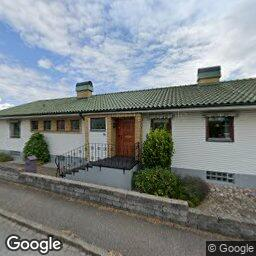

[[292.64856]]
datasets\good basement streetviews\pic_VALBORGSGATAN 49, MALMÖ.jpg


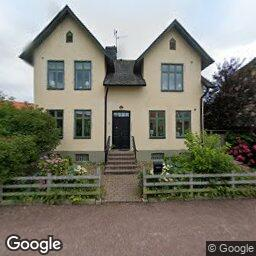

[[522.3063]]
datasets\good basement streetviews\pic_TRINDELVÄGEN 7, MALMÖ.jpg


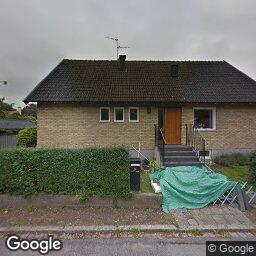

[[1596.203]]
datasets\good basement streetviews\pic_GREVEGATAN 49, MALMÖ.jpg


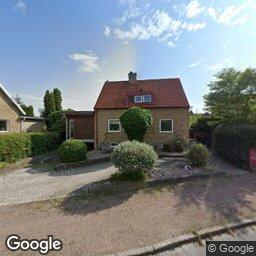

[[1185.0415]]
datasets\good basement streetviews\pic_FÖRENINGSGATAN 53A, MALMÖ.jpg


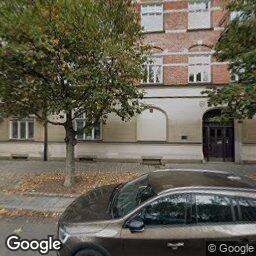

[[1628.5564]]
datasets\good basement streetviews\pic_BELESHÖGSVÄGEN 12, MALMÖ.jpg


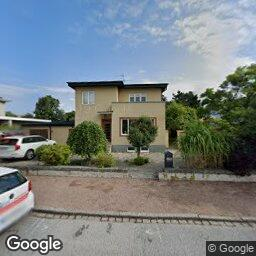

[[472.39426]]
datasets\good basement streetviews\pic_BOKTRYCKAREGATAN 11A, MALMÖ.jpg


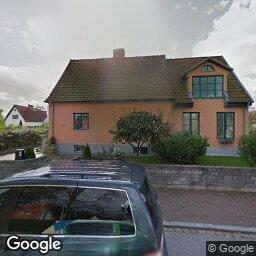

[[926.8881]]
datasets\good basement streetviews\pic_LÅNGGÅRDSGATAN 19, MALMÖ.jpg


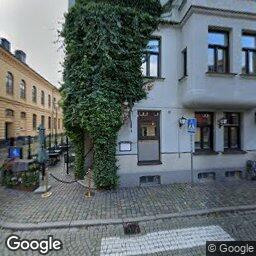

[[662.1268]]
datasets\good basement streetviews\pic_KRUKMAKAREGATAN 11, MALMÖ.jpg


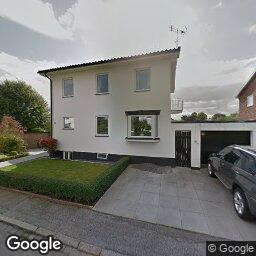

[[47.42908]]
datasets\good basement streetviews\pic_ÖSTRA STALLMÄSTAREGATAN 10, MALMÖ.jpg


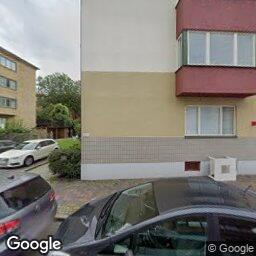

----------------------------------------------
[[-459.48206]]
datasets\good non basement streetviews\pic_GÖTGATAN 7A, MALMÖ.jpg


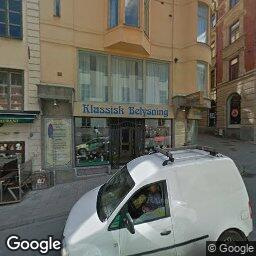

In [101]:
preprocess_input = keras.applications.vgg16.preprocess_input

img_size = (150, 150)
last_conv_layer_name = "block5_conv3"

basement_folder = "basement"
non_basement_folder = "non_basement"

for file in basement_test_sample:
    img_path = os.path.join(good_basement_dir, file)
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    preds = new_model.predict(img_array)
    
    if preds<0:
        heatmap = make_gradcam_heatmap(img_array, new_model, last_conv_layer_name)
        #save_and_display_gradcam(img_path, heatmap, os.path.join(gradcam_save, basement_folder, file))
    else:
        print(preds)
        print(img_path)
        display(Image(img_path))

print('----------------------------------------------')

for file in non_basement_test_sample:
    img_path = os.path.join(good_non_basement_dir, file)
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    preds = new_model.predict(img_array)
    
    if preds>0:
        heatmap = make_gradcam_heatmap(img_array, new_model, last_conv_layer_name)
        #save_and_display_gradcam(img_path, heatmap, os.path.join(gradcam_save, non_basement_folder, file))
    else:
        print(preds)
        print(img_path)
        display(Image(img_path))

# Plotting of ROC-curves

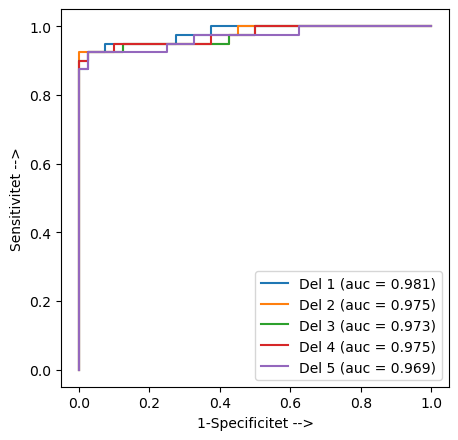

In [22]:
from sklearn.metrics import roc_curve
y_true = np.array([False] * 40 + [True] * 40)
plt.figure(figsize=(5,5), dpi=100)

for i in range(1,6):
    model = models.load_model(f'vgg16_5fold_no_augmentation_14epochs_fold{i}.h5')
    #model = models.load_model(f'vgg16_5fold_augmentation_no_brightness_14epochs_fold{i}.h5')
    #model = models.load_model(f'vgg16_5fold_augmentation_brightness_14epochs_fold{i}.h5')
    
    y_pred = model.predict(test_generator2)
    y_pred = y_pred.flatten()
    
    fpr, tpr, threshold = roc_curve(y_true, y_pred, drop_intermediate=False)
    auc = sklearn.metrics.auc(fpr, tpr)
    
    plt.plot(fpr, tpr, linestyle='-', label=f'Del {i} (auc = {np.round(auc,3)})')
    
plt.xlabel('1-Specificitet -->')
plt.ylabel('Sensitivitet -->')
plt.legend()
plt.show()

# Test on images with occlusion

In [10]:
basement_dir = os.path.join(base, 'basement streetviews')
basement = os.listdir(basement_dir)
bad_basement = [file for file in basement if file not in good_basement_files]
basement_size = np.size(bad_basement)

non_basement_dir = os.path.join(base, 'non basement streetviews')
non_basement = os.listdir(non_basement_dir)
bad_non_basement = [file for file in non_basement if file not in good_non_basement_files]
non_basement_size = np.size(bad_non_basement)

n_test = basement_size + non_basement_size

#remove old test files
for file in os.listdir(test_basement_dir):
    os.remove(os.path.join(test_basement_dir, file))
for file in os.listdir(test_non_basement_dir):
    os.remove(os.path.join(test_non_basement_dir, file))

#add new test files
for file in bad_basement:
    shutil.copy(os.path.join(basement_dir, file), test_basement_dir)
for file in bad_non_basement:
    shutil.copy(os.path.join(non_basement_dir, file), test_non_basement_dir)

In [13]:
n_test

2303

In [27]:
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=231,
        class_mode='binary',
        shuffle=False)

Found 2303 images belonging to 2 classes.


10/10 [==============================] - 299s 30s/step - loss: 1.8686 - acc: 0.4933
Score for fold 1: loss of 1.8686048984527588; acc of 49.32696521282196%
[[ 882 1124]
 [  43  254]]
10/10 [==============================] - 297s 30s/step - loss: 1.9896 - acc: 0.4868
Score for fold 2: loss of 1.9895737171173096; acc of 48.67564141750336%
[[ 878 1128]
 [  54  243]]
10/10 [==============================] - 296s 30s/step - loss: 2.5755 - acc: 0.4763
Score for fold 3: loss of 2.575544834136963; acc of 47.633522748947144%
[[ 853 1153]
 [  53  244]]
10/10 [==============================] - 300s 30s/step - loss: 1.5093 - acc: 0.6635
Score for fold 4: loss of 1.509310007095337; acc of 66.34824275970459%
[[1318  688]
 [  87  210]]
10/10 [==============================] - 303s 30s/step - loss: 3.8336 - acc: 0.4672
Score for fold 5: loss of 3.8335933685302734; acc of 46.72166705131531%
[[ 831 1175]
 [  52  245]]
------------------------------------------------------------------------
Score per fol

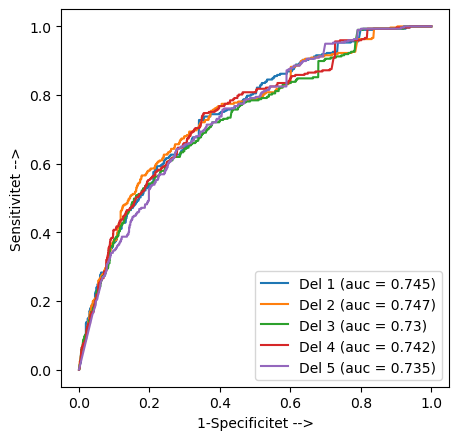

In [30]:
from sklearn.metrics import roc_curve
y_true = np.array([False] * basement_size + [True] * non_basement_size)
plt.figure(figsize=(5,5), dpi=100)

acc_per_fold = []
loss_per_fold = []

for i in range(1,6):
    #model = models.load_model(f'vgg16_5fold_no_augmentation_14epochs_fold{i}.h5')
    #model = models.load_model(f'vgg16_5fold_augmentation_no_brightness_14epochs_fold{i}.h5')
    model = models.load_model(f'vgg16_5fold_augmentation_brightness_14epochs_fold{i}.h5')
    
    scores = model.evaluate(test_generator)
    print(f'Score for fold {i}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    probabilities = model.predict(test_generator)
    y_pred = probabilities > 0.5

    print(confusion_matrix(y_true, y_pred))
    
    y_pred = probabilities.flatten()
    
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    auc = sklearn.metrics.auc(fpr, tpr)
    
    plt.plot(fpr, tpr, linestyle='-', label=f'Del {i} (auc = {np.round(auc,3)})')

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')    

plt.xlabel('1-Specificitet -->')
plt.ylabel('Sensitivitet -->')
plt.legend()
plt.show()